# Assignment 4
L'obiettivo di questo assignment è studiare un approccio Transfer Learning basato sull'architettura VGG 16 per il riconoscimento di immagini. 

Il dataset scelto per questo task è disponibile al seguente link: https://www.kaggle.com/ikarus777/best-artworks-of-all-time. Consiste nel riconoscimento del pittore che ha realizzato un determinato quadro a partire dall'analisi dell'immagine dello stesso. Il dataset in forma originale contiene 50 classi (corrispondenti a 50 pittori), per poter rispettare il vincolo imposto ho selezionato un subset da 10 classi, corrispondenti ai pittori: 

*   Amedeo Modigliani
*   Andy Warhol 
*   Caravaggio
*   Claude Monet 
*   Gustav Klimt
*   Leonardo Da Vinci
*   Michelangelo
*   Pablo Picasso
*   Salvador Dalì
*   Vincent Van Gogh

Il dataset completo contiene 2076 osservazioni. Per evitare il caricamento di tutte le immagini su Drive è stata effettuata una fase di preprocessing offline nella quale per ogni immagine: 

*  È stata caricata nella dimensione corretta (224 x 224)
*  È stata trasformata in un array 
*  È stata applicata la funzione expand
*  È stato salvato l'array ottenuto, il nome del pittore, un valore numerico corrispondente al pittore (0-9) e il nome del file. 

La lista ottenuta è salvata in un file obj.
Lo script utilizzato per questa fase verrà allegato in fase di consegna insieme al file obj. 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np 
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Connessione a Google Drive per la lettura del dataset. 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = "/content/gdrive/MyDrive"
base_dir = root_dir + '/AML-21-22-practicals'

Mounted at /content/gdrive


Lettura del dataset e caricamento in una lista. Caricamento del modello base VGG 16. 

In [ ]:
import pickle 
filename = base_dir + "/images.obj"
ds = pickle.load(open(filename,"rb"))

train_set = []
labels = []
for el in ds:
    train_set.append(preprocess_input(el[0]))
    labels.append(el[3])

base_model = VGG16(weights = 'imagenet')

# Scelta del modello 
Per tutti gli esperimenti è stato scelto di utilizzare una Support Vector Machine. È stata effettuata una piccola fase di tuning manuale per la scelta dei parametri ed è risultato che le performance vengono massimizzate per i seguenti valori: 

*   Kernel: *rbf*
*   Gamma: valore di default --> 1 / (n_features * X.var())
*   C: 10

Questi valori sono stati mantenuti costanti per tutti i 3 esperimenti. 

Per confrontare i risultati a fronte di diversi tagli è stato deciso di applicare la PCA in tutti gli esperimenti. Inoltre è stato osservato come il valore scelto di varianza da mantenere dalle feature influisce sul risultato, pertanto è stato deciso di mantenerlo fisso per tutti. In particolare per tagli posizionati all'inizio della rete, quindi che restituiscono un numero elevato di feature è necessario tenerne solo una piccola parte (quindi circa il 30 % della varianza); mentre per tagli posizionati alla fine della rete non sarebbe necessaria la PCA o comunque mantenendo un numero elevato di feature (circa il 90% della varianza) è stato pertanto deciso di utilizzare un valore medio per tutti i tre esperimenti: circa il 70% della varianza.  

# Primo esperimento
Per il primo esperimento è stato pensato di scegliere un taglio in un layer abbastanza iniziale: pooling a livello di block 3. Per ogni elemento del dataset è stato calcolata la rappresentazione con la rete VGG, quindi è stata applicata la funzione di reshape per ottenere un array ad un sola dimensione, in modo che possa essere utilizzato come input per una SVM. 
Si ottiene un numero abbastanza elevato di feature: 200704, che dopo l'applicazione della PCA diventano 728.   
È stato osservato che il taglio tra train e test set può influire sul risultato, per questo sono stati effettuati 10 allenamenti della rete e viene riportato il valore medio di accuratezza. Per questo primo esperimento il valore si attesta sui 0.79. Diminuendo la percentuale di varianza di feature da mantenere, quindi ottenendo un numero di feature inferiore è possibile ottenere risultati migliori.

In [ ]:
reducted_features = []
number_features = []

model = Model(inputs = base_model.input, outputs = base_model.get_layer('block3_pool').output)
model.summary()

for el in train_set:
    predict_feature = model.predict(el)
    predict_feature = predict_feature.reshape((len(predict_feature), np.prod(predict_feature.shape[1:])))
    reducted_features.append(predict_feature[0])
  
reducted_features = np.array(reducted_features)
reducted_features.shape

pca = PCA(0.70)
p_component = pca.fit_transform(reducted_features)
print(p_component.shape)
number_features.append(p_component.shape[1])

accuracy_one = []
svm_one = svm.SVC(C = 10)

for i in range(0,10):
  x_train, x_test, y_train, y_test = train_test_split(p_component, labels, test_size = 0.20)

  svm_one.fit(x_train, y_train)

  predicted = svm_one.predict(x_test)

  print(accuracy_score(y_test, predicted))
  accuracy_one.append(accuracy_score(y_test, predicted))


print("Accuracy media = ", sum(accuracy_one) / len(accuracy_one))

del reducted_features, model, predict_feature, p_component, x_train, x_test, y_train, y_test, predicted

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Secondo esperimento

Per il secondo esperimento è stato pensato di scegliere un taglio in un layer che più si avvicina ai layer fully-connected, è stato quindi scelto il layer: block5_conv3. Per ogni elemento del dataset è stata calcolata la rappresentazione con la rete VGG, quindi è stata applicata la funzione di reshape per ottenere un array ad un sola dimensione, in modo che possa essere utilizzato come input ad una SVM. 
Si ottiene un numero abbastanza elevato di feature: 401408, che dopo l'applicazione della PCA diventano 672.   
È stato osservato che il taglio tra train e test set può influire sul risultato, per questo sono stati effettuati 10 allenamenti della rete e viene riportato il valore medio di accuratezza. Per questo secondo esperimento il valore si attesta sui 0.77. Diminuendo il numero di feature è possibile ottenere risultati migliori, andrebbe diminuito il parametro in input della PCA che rappresenta la percentuale di varianza da mantenere.

In [ ]:
reducted_features = []

model = Model(inputs = base_model.input, outputs = base_model.get_layer('block5_conv3').output)
model.summary()

for el in train_set:
    predict_feature = model.predict(el)
    predict_feature = predict_feature.reshape((len(predict_feature), np.prod(predict_feature.shape[1:])))
    reducted_features.append(predict_feature[0])
  
reducted_features = np.array(reducted_features)
reducted_features.shape


pca = PCA(0.70)
p_component = pca.fit_transform(reducted_features)
print(p_component.shape)
number_features.append(p_component.shape[1])

accuracy_two = []
svm_two = svm.SVC(C = 10)

for i in range(0,10):
  x_train, x_test, y_train, y_test = train_test_split(p_component, labels, test_size = 0.20)

  svm_two.fit(x_train, y_train)

  predicted = svm_two.predict(x_test)

  print(accuracy_score(y_test, predicted))
  accuracy_two.append(accuracy_score(y_test, predicted))


print("Accuracy media = ", sum(accuracy_two) / len(accuracy_two))
del reducted_features, model, predict_feature, p_component, svm_two, x_train, x_test, y_train, y_test, predicted

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Terzo esperimento
Per il terzo esperimento è stato pensato di scegliere un taglio in un layer fully-connected: fc2. Per ogni elemento del train set è stato calcolata la rappresentazione con la rete VGG, in questo caso non serve applicare la funzione di reshape perchè l'input è già ad una dimensione. Si ottiene un numero abbastanza ridotto di feature: 4096. Dopo l'applicazione della PCA questo valore si riduce ulteriormente a 105.  È stato osservato che il taglio tra train e test set può influire sul risultato, per questo sono stati effettuati 10 allenamenti della rete e viene riportato il valore medio di accuratezza. Per questo terzo esperimento il valore si attesta sui 0.84. 

In [ ]:
reducted_features = []

model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc2').output)
model.summary()

for el in train_set:
    predict_feature = model.predict(el)
    reducted_features.append(predict_feature[0])
  
reducted_features = np.array(reducted_features)
reducted_features.shape


pca = PCA(0.70)
p_component = pca.fit_transform(reducted_features)
print(p_component.shape)
number_features.append(p_component.shape[1])

accuracy_three = []
svm_three = svm.SVC(C = 10)

for i in range(0,10):
  x_train, x_test, y_train, y_test = train_test_split(p_component, labels, test_size = 0.20)

  svm_three.fit(x_train, y_train)

  predicted = svm_three.predict(x_test)

  print(accuracy_score(y_test, predicted))
  accuracy_three.append(accuracy_score(y_test, predicted))

print("Accuracy media = ", sum(accuracy_three) / len(accuracy_three))
del reducted_features, model, predict_feature, p_component, svm_three, x_train, x_test, y_train, y_test, predicted

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Confronto tra i tre esperimenti e conclusioni
Come è possibile vedere il taglio effettuato a livello di layer fully-connected permette di ottenere prestazioni migliori, quindi è possibile assumere che il task in oggetto non differisca troppo dal task "Imagenet". Tuttavia osservando le prestazioni sui tagli ottenuti nei primi due esperimenti (quindi tagliando a livello di pooling layer e layer convoluzionale) si nota che applicando la PCA, diminuendo quindi il numero di feature in input alla SVM le prestazioni aumentano, inoltre è stato osservato come aumentando ulteriormente la percentuale di riduzione delle feature attraverso PCA le prestazioni nei primi due casi aumentano ulteriormente. 
Quindi è possibile concludere come le percentuali maggiori ottenute sui layer fully-connected siano date dal numero minore di feature ottenute e le stesse performance possano essere ottenute tagliando sui layer iniziali e applicando una riduzione maggiore con PCA. È stato inoltre osservato come il numero ottimale di feature (quello che produce le performance migliori) si ottiene per circa 100 feature. 

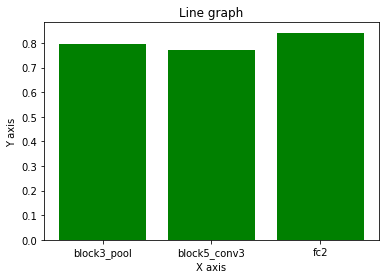

In [ ]:
accuracy_media = [sum(accuracy_one)/len(accuracy_one), sum(accuracy_two)/len(accuracy_two), sum(accuracy_three)/len(accuracy_three)]

accuracy_media = np.array(accuracy_media)

import matplotlib.pyplot as plt

plt.title("Accuracy")
plt.bar(["block3_pool", "block5_conv3", "fc2"],height = accuracy_media, color ="green")
plt.show()

In questo primo grafico è possibile vedere la differenza di accuracy ottenuta in base al taglio effettuato. Come si può vedere tagliando a livello del secondo layer fully-connected l'accuracy è maggiore. 

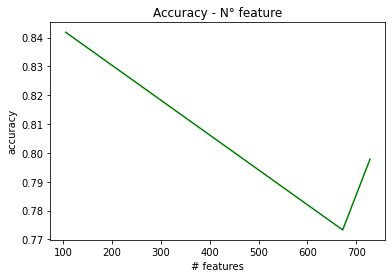

In [ ]:
plt.title("Accuracy - N° feature")
plt.xlabel("# features")
plt.ylabel("accuracy")
plt.plot(number_features, accuracy_media, color ="green")
plt.show()

Come si può vedere da questo secondo grafico il valore di accuracy decresce al crescere del numero di features, questo è dovuto alla natura del classificatore scelto (SVM) che non è troppo performante in corrispondenza di un numero troppo elevato di feature. Inoltre diminuendo la percentuale di varianza da mantenere nella PCA è possibile ottenere buone prestazioni anche tagliando la rete ad un layer iniziale. 